In [4]:
using DifferentialEquations
using Plots
using Flux

┌ Warning: The NVIDIA driver on this system only supports up to CUDA 11.0.0.
│ For performance reasons, it is recommended to upgrade to a driver that supports CUDA 11.2 or higher.
└ @ CUDA /opt/julia/packages/CUDA/fRSUT/src/initialization.jl:42


# Model a spring's force

In [5]:
spring_force!(du, u, p, t) = -p * u + 0.1 * sin(u)

parameters = 1.0
tspan = (0.0, 10.0)

# Declare the problem and solve the solution
prob = SecondOrderODEProblem(spring_force!, 1.0, 0.0, tspan, parameters)
sol = solve(prob, alg_hint = :auto)

# Get some force data to build a neural net off of
t_to_grab = 0:3.3:10.0
positions = [output[2] for output in sol(t_to_grab)]
actual_forces = [spring_force!(output[1], output[2], parameters, t_to_grab) for output in sol(t_to_grab)]

4-element Vector{Float64}:
  0.0
  0.011132586748088041
 -0.02231974976704535
  0.03355031653924814

## Plot the solution to the ODE

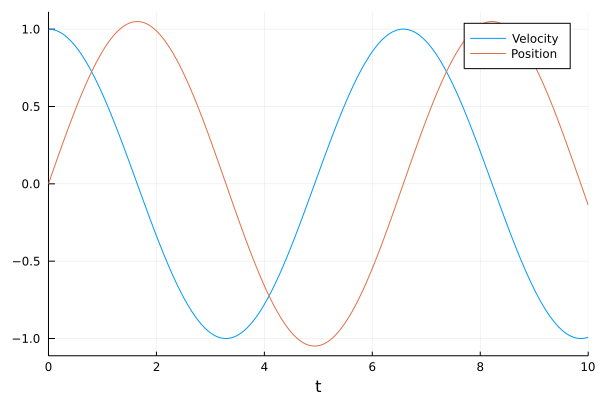

In [9]:
plot(sol, label = ["Velocity" "Position"])

# Neural net model from the spring data

In [8]:
# Neural net architecture
ForceNN = Chain(x -> [x],
                Dense(1, 32, tanh),
                Dense(32, 1),
                first)

# Create loss which will use the spring data to calculate the loss
# (predict the force based upon prediction then minus the actual force for that position)
# (take the absolute square of that to make sure it's positive)
# (sum up all of losses for a batch)
data_loss() = sum(abs2, ForceNN(positions[x]) - actual_forces[x] for x in 1:length(positions))

# Optimiser (gradient descent)
opt = Flux.Descent(0.01)

# Data (5000 iterations of the 5 positions (inputs) and 5 forces (outputs))
data = Iterators.repeated((), 5000)

# Callback, every 500 iterations output the data_loss
num_of_iterations = 0
cb = function ()
    global num_of_iterations += 1
    if num_of_iterations % 500 == 0
        display(data_loss())
    end
end

# Train the neural net
Flux.train!(data_loss, Flux.params(ForceNN), data, opt; cb = cb)

0.0014598262364331586

0.0012597230127394908

0.0010867557396535548

0.0009371776890419346

0.0008078063803750638

0.0006959180632552257

0.0005991764059320733

0.0005155635956952703

0.0004433360037599956

0.00038097987499944826

# Plot the neural net's force predictions vs force actuals

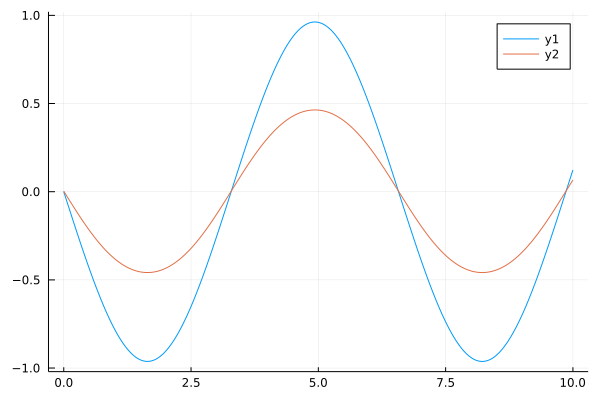

In [10]:
# Set the time span
t = 0:0.01:10

# Get the positions to predict (0 - 10 with 0.01 jumps)
positions_to_predict = [output[2] for output in sol(t)]

# Get the force actuals (using the solved ODE `spring_force!` earlier)
# Get the force predictions (using the neural network)
force_actuals = [spring_force!(output[1], output[2], parameters, t) for output in sol(t)]
force_predictions = ForceNN.(positions_to_predict)

# Plot the two to see how the neural net did vs actuals
plot(t, force_actuals)
plot!(t, force_predictions)

# The neural net does an ok job at capturing the dynamics but fails at modelling peaks and troughs

# Encorporating Hooke's law

In [11]:
# Create hooke's law system and solve to then be able to generate forces using hooke's law to then feed into the neural net
hookes_law_force!(dx, x, k, t) = -k * x

# Declare problem + solve the solution
hooke_prob = SecondOrderODEProblem(hookes_law_force!, 1.0, 0.0, tspan, parameters)
hooke_sol = solve(hooke_prob, alg_hint = :auto)

# Comparing the model vs hooke's law (relatively similar)
plot(sol, label = ["Velocity" "Position"])
plot!(hooke_sol, linestyle = :dash)

# Generate random positions between -1 and 1 using 2 * rand() - 1 (input data)
# It's important the values are between -1 and 1 as that is what our inputs range from
random_positions = [2 * rand() - 1 for i in 1:100]

# Define loss function for the ODE (hooke's law)
# i.e. How does our predicted force match up with hooke's law force at a position
# - The (-1.0 * x) is factoring in hooke's law, 1.0 is our k
# - At the start, similar to data_loss() it will be bad, goal is to minimise it
hooke_loss() = sum(abs2, ForceNN(random_positions[x]) - (-1.0 * random_positions[x]) for x in 1:length(random_positions))

# Combining the losses (neural net and physics) and weight them
# - Weighting is similar to saying I want my prediction to be more like e.g. the actual data gathered
combined_loss() = data_loss() + 0.1 * hooke_loss()

# Optimiser (gradient descent)
opt = Flux.Descent(0.01)

# Data (5000 iterations of the random positions)
data = Iterators.repeated((), 5000)

# Callback, every 500 iterations output the combined_loss
num_of_iterations = 0
cb = function ()
    global num_of_iterations += 1
    if num_of_iterations % 500 == 0
        display(combined_loss())
    end
end

# Train the neural net with the new loss function
Flux.train!(combined_loss, Flux.params(ForceNN), data, opt; cb = cb)

0.0004516905745784749

0.00043333973009692604

0.0004164321309714725

0.00040080153073946757

0.0003863068313386623

0.0003728279445536749

0.00036026121797092436

0.0003485188955869449

0.000337522321752224

0.00032720256803548574

In [14]:
# Get the force predictions (using the neural network that was trained with the combined_loss)
# i.e. one that considers actual forces AND force's based upon hooke's law
force_predictions = ForceNN.(positions_to_predict);

# Plot the two to see how the neural net did vs actuals

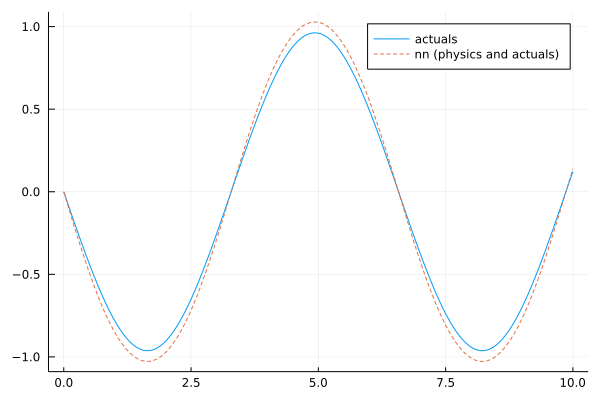

In [15]:
plot(t, force_actuals, label = "actuals")
plot!(t, force_predictions, linestyle = :dash, label = "nn (physics and actuals)")

# A much better performance that models the peaks and troughs much better